<a href="https://colab.research.google.com/github/DrAlexSanz/Amazon-reviews-dataset/blob/master/Sentiment_analysis_Amazon_reviews_NN_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is a quick notebook to perform binary classification on the amazon reviews dataset

### Idea of this notebook.

1. Get the data.
2. Combine it in one DF or vector or something.
3. Label encoding.
4. Tokenize.
5. Train/test split.
6. Model training and testing using a quick benchmark. Simple NN, RNN and LSTM as a test of what I can achieve with simple models.

In [1]:
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras import Sequential
from keras.layers import Input, Dense, Dropout, Embedding, Activation, RNN, LSTM, SimpleRNN
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the data and store positive and negative reviews

The data is in xml format. Read it with bs4.

The idea is to find all the reviews text. findAll finds the text and the tags and produces a soup object result. I want a string and then I'll split it and clean the "\n". This is the way to do things.

In [2]:
pos_reviews = BeautifulSoup(open("positive.review").read())
neg_reviews = BeautifulSoup(open("negative.review").read())

pos_list = []

pos_revs = pos_reviews.find_all("review_text")

for rev in pos_revs:
    pos_list.append(rev.text)
    

neg_list = []

neg_revs = neg_reviews.find_all("review_text")

for rev in neg_revs:
    neg_list.append(rev.text)


## Remove the \n characters.

### I have a list of strings, for each string I replace the \n with a blank space and then I strip the leading and trailing spaces. On pos_list I just replace the \n by an inexisting character. Both works, the inexisting character is probably better and more elegant but since I had to do the NLS at Cat I can also do it here ;)

In [3]:
clean_pos_list =[elem.replace("\n", "") for elem in pos_list]

clean_neg_list =[elem.replace("\n", " ").strip() for elem in neg_list]




### Out of curiosity, check how long are the reviews. Vaya tochos sin resumen. Es de vergüenza su actitud.

In [4]:
max_len = [len(elem) for elem in clean_pos_list]
longest = max(max_len)
print(longest)

max_len_neg = [len(elem) for elem in clean_neg_list]
print(max(max_len))

5840
5840


## Now I will tag the pos and negs myself. I don't need label encoding.
### Then union the two dataframes

In [5]:
pos = pd.DataFrame(clean_pos_list, columns = ["Reviews"])
pos["label"] = 1

neg = pd.DataFrame(clean_neg_list, columns = ["Reviews"])
neg["label"] = 0

dataset = pd.concat([pos, neg], ignore_index = True)

## It's probably not the best way to do this but I put the tags, concat both DFs and now I'll make two vectors and tokenize.

In [6]:
X = dataset["Reviews"]
y = dataset["label"]

y = y.values.tolist()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [8]:
print(x_test)

681     Great buy for a wonderful speaker system. Work...
1601    I bought these cables, brought them home and i...
819     I had a problem with my Sunrocket VOIP and I r...
910     I am extremely pleased with the purchase. I am...
330     I'm using this AP, along with a Netgear 802.11...
                              ...                        
1685    i was very disappointed with the ge superadio ...
152     PROS:smallreliablevery good quality with pictu...
351     I recently bought a new 6.0 megapixel digital ...
266     Myself and my grandchildren love to hold these...
1559    OK. I take my words back. I found a solution t...
Name: Reviews, Length: 400, dtype: object


In [9]:
vocab_size = 10000

tok = Tokenizer(num_words = vocab_size, oov_token = 1) # For the unknown/ out of vocab. words.

tok.fit_on_texts(x_train)

sequences = tok.texts_to_sequences(x_train)

train_matrix = sequence.pad_sequences(sequences, 5840, padding = "post") # 5840 was the max length.

sequences_test = tok.texts_to_sequences(x_test)

test_matrix = sequence.pad_sequences(sequences_test, 5840, padding = "post")


In [10]:
test_matrix.shape

(400, 5840)

In [11]:
# Convert y to np array

y_test = np.array(y_test)
y_train = np.array(y_train)

### Up to here it was the same thing. Preprocessing is common, the ML/AI is the less relevant part.

#### Now I'll do three models. A dense and an RNN/LSTM one.

In [12]:
def plain():
    inputs = Input(name = "inputs", shape = [longest])
    layer = Embedding(input_dim = vocab_size, output_dim = 50, input_length = max_len)(inputs)
    layer = Dense(units = 256)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 128)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 64)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 32)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 16)(layer)
    layer = Activation("relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units = 8)(layer)
    layer = Activation("relu")(layer)
    layer = Dense(units = 1)(layer)
    output = Activation("sigmoid")(layer)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

### Now let's create the model and make a summary

In [13]:
plain_model = plain()

plain_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5840)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 5840, 50)          500000    
_________________________________________________________________
dense (Dense)                (None, 5840, 256)         13056     
_________________________________________________________________
activation (Activation)      (None, 5840, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5840, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 5840, 128)         32896     
_________________________________________________________________
activation_1 (Activation)    (None, 5840, 128)        

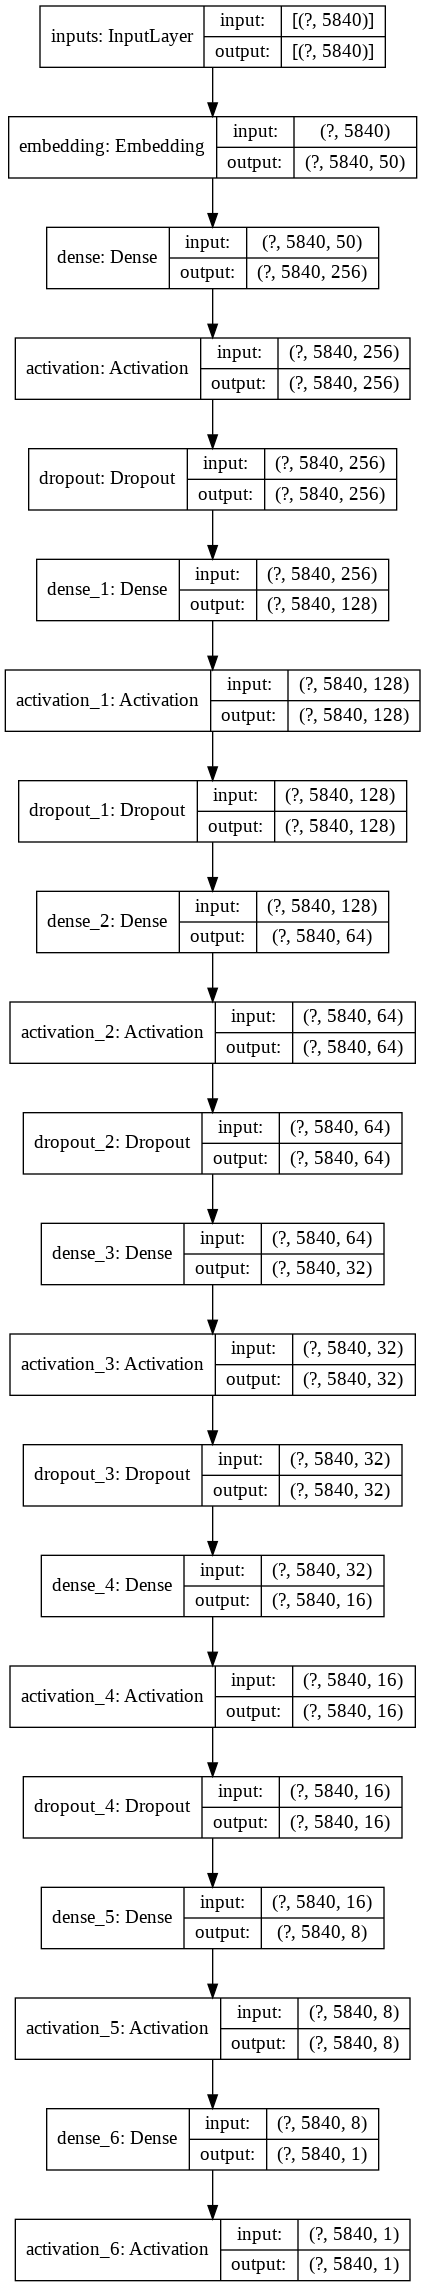

In [14]:
plot_model(plain_model, show_shapes = True, show_layer_names = True)

### There is probably going to be a crazy overfitting, but let's do it.

In [15]:
plain_model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = ["accuracy"])

#Uncomment for training

plain_model.fit(train_matrix, y_train, batch_size = 256, epochs = 10, validation_split = 0.2)

Epoch 1/10
5/5 [==============================] - 3s 577ms/step - loss: 0.6933 - accuracy: 0.4953 - val_loss: 0.6934 - val_accuracy: 0.4812
Epoch 2/10
5/5 [==============================] - 3s 512ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6933 - val_accuracy: 0.4812
Epoch 3/10
5/5 [==============================] - 3s 519ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4812
Epoch 4/10
5/5 [==============================] - 3s 527ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.4812
Epoch 5/10
5/5 [==============================] - 3s 519ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4812
Epoch 6/10
5/5 [==============================] - 3s 524ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4812
Epoch 7/10
5/5 [==============================] - 3s 525ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.4812
Epoch 8/10
5/5 [====

## It didn't learn much. Probably it's just that the network is learning the logistic regression or something similar to that separation.

### Let's do an RNN and later an LSTM

In [16]:
def plain_RNN():
    inputs = Input(name = "inputs", shape = [longest])
    layer = Embedding(input_dim = vocab_size, output_dim = 250, input_length = max_len)(inputs)
    layer = SimpleRNN(units = 250, activation = None)(layer)
    layer = Activation("elu")(layer)
    layer = Dropout(0.25)(layer)
    layer = Dense(units = 150)(layer)
    layer = Activation("elu")(layer)
    layer = Dropout(0.25)(layer)
    layer = Dense(units = 100)(layer)
    layer = Activation("elu")(layer)
    layer = Dropout(0.25)(layer)
    layer = Dense(units = 50)(layer)
    layer = Activation("elu")(layer)
    layer = Dropout(0.25)(layer)
    layer = Dense(units = 1)(layer)
    output = Activation("sigmoid")(layer)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [17]:
rnn_model = plain_RNN()

rnn_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 5840)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5840, 250)         2500000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 250)               125250    
_________________________________________________________________
activation_7 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               37650     
_________________________________________________________________
activation_8 (Activation)    (None, 150)              

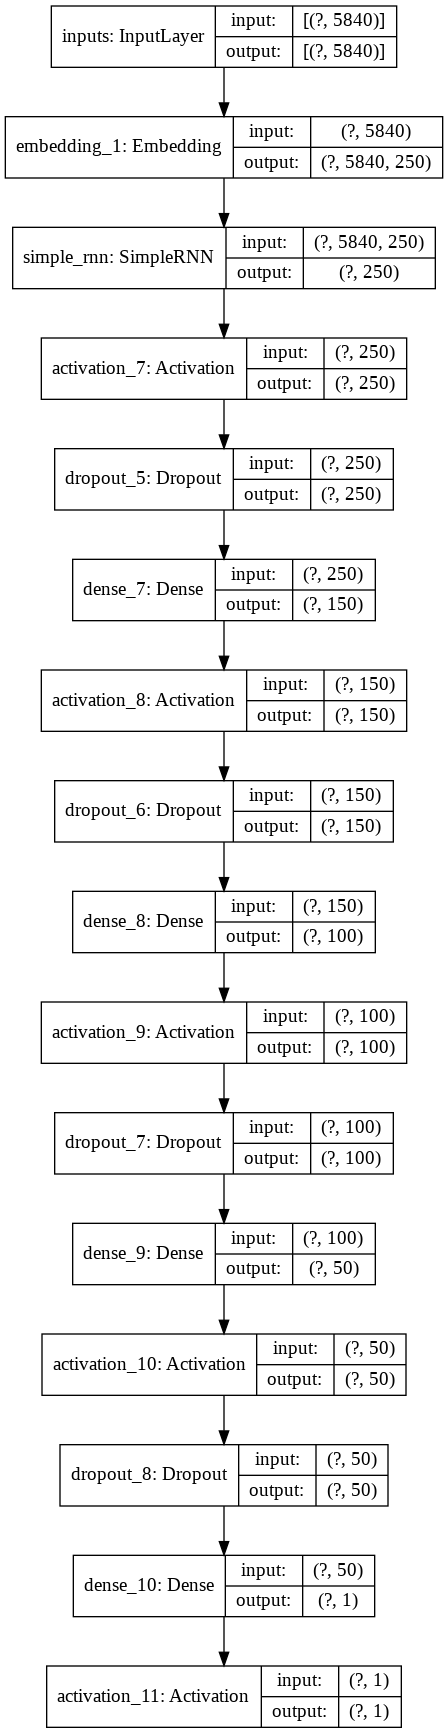

In [18]:
plot_model(rnn_model, show_shapes = True, show_layer_names = True)

In [19]:
rnn_model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = ["accuracy"])

#Uncomment for training

rnn_model.fit(train_matrix, y_train, batch_size = 256, epochs = 10, validation_split = 0.2)

Epoch 1/10
5/5 [==============================] - 27s 5s/step - loss: 9872.9980 - accuracy: 0.5102 - val_loss: 148.5186 - val_accuracy: 0.5219
Epoch 2/10
5/5 [==============================] - 28s 6s/step - loss: 98.7204 - accuracy: 0.5063 - val_loss: 41.4767 - val_accuracy: 0.5188
Epoch 3/10
5/5 [==============================] - 28s 6s/step - loss: 46.4210 - accuracy: 0.4945 - val_loss: 23.9172 - val_accuracy: 0.5188
Epoch 4/10
5/5 [==============================] - 28s 6s/step - loss: 21.1841 - accuracy: 0.5023 - val_loss: 6.7351 - val_accuracy: 0.5188
Epoch 5/10
5/5 [==============================] - 28s 6s/step - loss: 6.7805 - accuracy: 0.5117 - val_loss: 3.7671 - val_accuracy: 0.5188
Epoch 6/10
5/5 [==============================] - 28s 6s/step - loss: 4.2474 - accuracy: 0.4969 - val_loss: 2.7331 - val_accuracy: 0.5188
Epoch 7/10
5/5 [==============================] - 28s 6s/step - loss: 2.7791 - accuracy: 0.5016 - val_loss: 1.9028 - val_accuracy: 0.5188
Epoch 8/10
5/5 [========